# Elaborato

## Install

In [1]:
pip install tensorflow_privacy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install dill

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Import

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sk
import os
import sys
import collections
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle
import dill

from typing import Tuple
from scipy import special
from sklearn import metrics
from scipy import special
from numpy import indices
from tensorflow import keras
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_score, recall_score, f1_score, classification_report
from keras.utils.vis_utils import plot_model

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)


2022-07-26 17:24:00.713244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-26 17:24:00.713261: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#dill.load_session('mia_tfp_mmist_001.db')

2022-07-26 15:08:24.594405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 15:08:24.594817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-26 15:08:24.594884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-26 15:08:24.594946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-26 15:08:24.595006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [2]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report
import tensorflow_privacy

## Dataset

In [3]:
num_classes = 10
activation = 'relu'
batch_size = 50
epochs_per_report = 2
total_epochs = 50
lr = 0.001
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
reg_lambda = 0.01

In [5]:
print('Loading the dataset.')
train_ds = tfds.as_numpy(
    tfds.load('fashion_mnist', split=tfds.Split.TRAIN, batch_size=-1))
test_ds = tfds.as_numpy(
    tfds.load('fashion_mnist', split=tfds.Split.TEST, batch_size=-1))

x_train = train_ds['image'].astype('float32') / 255.
y_train_indices = train_ds['label'][:, np.newaxis]
x_test = test_ds['image'].astype('float32') / 255.
y_test_indices = test_ds['label'][:, np.newaxis]

print(y_test_indices )

x_train, x_toss, y_train_indices, y_toss = train_test_split(x_train, y_train_indices, test_size=0.5)
x_test, x_toss, y_test_indices, y_toss = train_test_split(x_test, y_test_indices, test_size=0.5)
x_train, x_valid, y_train_indices, y_valid_indices = train_test_split(x_train, y_train_indices, test_size=0.1)

y_train = tf.keras.utils.to_categorical(y_train_indices, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_indices, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid_indices, num_classes)

input_shape = x_train.shape[1:]
assert x_train.shape[0] % batch_size == 0, "The tensorflow_privacy optimizer doesn't handle partial batches"

Loading the dataset.
[[4]
 [4]
 [9]
 ...
 [6]
 [4]
 [1]]


In [6]:
name_label = ['tshirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankleboot']

In [7]:
y_train_indices[:, 0]

array([8, 6, 3, ..., 2, 9, 8])

In [8]:
x_train.shape[1:]

(28, 28, 1)

## Function

In [9]:
def small_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              regularizer: tf.keras.regularizers,
              activation: str = 'relu') -> tf.keras.models.Sequential:
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))

  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

  return model


In [10]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
  def __init__(self, epochs_per_report, model_name, attack):
    self.epochs_per_report = epochs_per_report
    self.model_name = model_name
    self.attack_results = []
    self.attack = attack

  def on_epoch_end(self, epoch, logs=None):
    epoch = epoch+1

    if epoch % self.epochs_per_report != 0:
      return

    print(f'\nRunning privacy report for epoch: {epoch}\n')

    logits_train = self.model.predict(x_train, batch_size=batch_size)
    logits_test = self.model.predict(x_test, batch_size=batch_size)

    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    privacy_report_metadata = PrivacyReportMetadata(
        accuracy_train=logs['val_accuracy'], 
        accuracy_test=logs['val_accuracy'],
        epoch_num=epoch,
        model_variant_label=self.model_name)

    attack_results = mia.run_attacks(
        AttackInputData(
            labels_train=y_train_indices[:, 0],
            labels_test=y_test_indices[:, 0],
            probs_train=prob_train,
            probs_test=prob_test),
        SlicingSpec(entire_dataset=True, by_class=True),
        attack_types=[self.attack],
        #AttackType.THRESHOLD_ATTACK,AttackType.LOGISTIC_REGRESSION,
        privacy_report_metadata=privacy_report_metadata)

    self.attack_results.append(attack_results)

In [11]:
def fit_and_report(title: str,
                  model: tf.keras.models.Sequential,
                  x_train, y_train, x_valid, y_valid, n_epochs, reports_tr, reports_lr):
    
    callback_threshold = PrivacyMetrics(epochs_per_report, title, AttackType.THRESHOLD_ATTACK)
    callback_logreg = PrivacyMetrics(epochs_per_report, title, AttackType.LOGISTIC_REGRESSION)

    history = model.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=n_epochs,
      validation_data=(x_valid, y_valid),
      callbacks=[callback_threshold, callback_logreg],
      shuffle=True)

    reports_tr.extend(callback_threshold.attack_results)
    reports_lr.extend(callback_logreg.attack_results)

    save_model(model, title)
    #save_report(callback.attack_results, title + '_report')

In [12]:
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

In [13]:
def load_model(filename):
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [14]:
def save_report(reports, filename):
    _file = filename + '.py'
    with open(_file, 'w') as file:
        file.write(reports)

In [15]:
def load_report():
    with open('reports.py', 'w') as file:
        return file.read(reports)

In [16]:
#dill.dump_session('mia_tfp_mmist_001.db')

## Base model 

In [17]:
mnist_reports_tr = []
mnist_reports_lr = []

In [18]:
model_base = small_cnn(input_shape, num_classes, num_conv=2, regularizer=None, activation=activation)

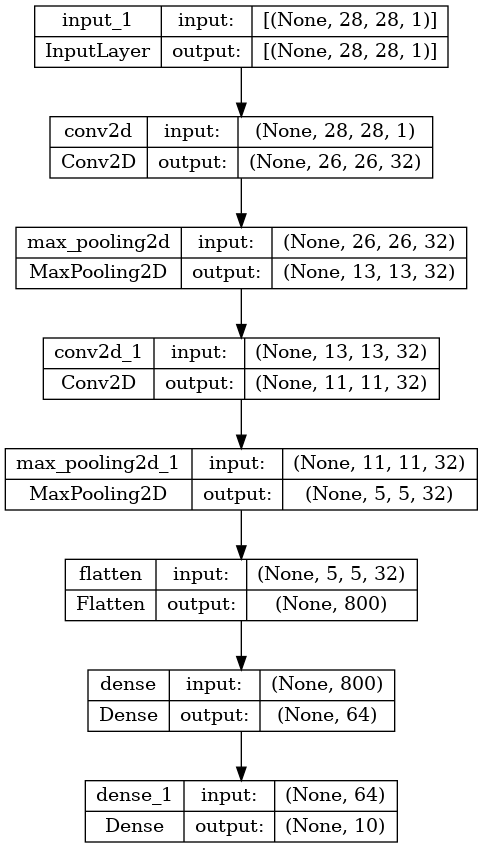

In [21]:
plot_model(model_base, show_shapes=True, show_layer_names=True)

In [18]:
fit_and_report('basemodel', model_base, x_train, y_train, x_valid, 
               y_valid, total_epochs, mnist_reports_tr, mnist_reports_lr)

Epoch 1/50
540/540 [==============================] - 5s 9ms/step - loss: 0.6447 - accuracy: 0.7679 - val_loss: 0.5006 - val_accuracy: 0.8123
Epoch 2/50
540/540 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8521
Running privacy report for epoch: 2

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 2

540/540 [==============================] - 14s 25ms/step - loss: 0.4131 - accuracy: 0.8521 - val_loss: 0.4469 - val_accuracy: 0.8323
Epoch 3/50
540/540 [==============================] - 5s 10ms/step - loss: 0.3600 - accuracy: 0.8711 - val_loss: 0.3664 - val_accuracy: 0.8670
Epoch 4/50
538/540 [============================>.] - ETA: 0s - loss: 0.3262 - accuracy: 0.8825
Running privacy report for epoch: 4

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 4

540/540 [==============================] - 13s 23ms/step - loss: 0.3265 - accuracy: 0.8823 - val_loss: 0.3517 - val_accuracy: 0.87

In [19]:
model_base.evaluate(x_test,y_test)

157/157 [==============================] - 1s 2ms/step - loss: 0.7459 - accuracy: 0.8976


[0.7458947896957397, 0.897599995136261]

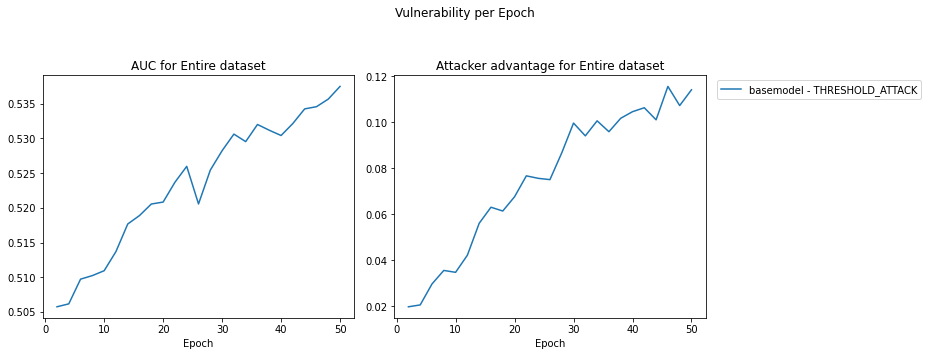

In [20]:
results_tr = AttackResultsCollection(mnist_reports_tr)
epoch_plot = privacy_report.plot_by_epochs(results_tr, privacy_metrics=privacy_metrics)

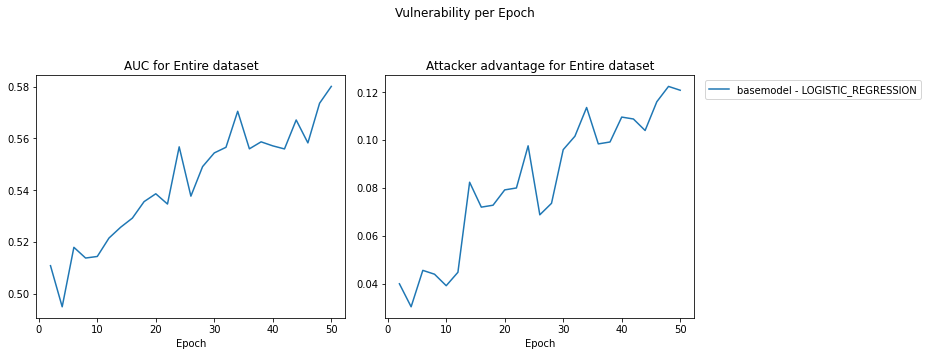

In [21]:
results_lr = AttackResultsCollection(mnist_reports_lr)
epoch_plot = privacy_report.plot_by_epochs(results_lr, privacy_metrics=privacy_metrics)

In [22]:
#dill.dump_session('mia_tfp_mmist_001.db')

## L1 regularization 

In [23]:
regL1 = tf.keras.regularizers.L1(l1=reg_lambda)

model_l1 = small_cnn(input_shape, num_classes, num_conv=2, regularizer=regL1, 
                       activation=activation)

In [24]:
fit_and_report('l1', model_l1, x_train, y_train, x_valid, y_valid, total_epochs, 
               mnist_reports_tr, mnist_reports_lr)

Epoch 1/50
540/540 [==============================] - 5s 9ms/step - loss: 1.4054 - accuracy: 0.7157 - val_loss: 0.7915 - val_accuracy: 0.7877
Epoch 2/50
537/540 [============================>.] - ETA: 0s - loss: 0.7429 - accuracy: 0.8017
Running privacy report for epoch: 2

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 2

540/540 [==============================] - 12s 22ms/step - loss: 0.7423 - accuracy: 0.8017 - val_loss: 0.7122 - val_accuracy: 0.7973
Epoch 3/50
540/540 [==============================] - 5s 9ms/step - loss: 0.6609 - accuracy: 0.8169 - val_loss: 0.6382 - val_accuracy: 0.8230
Epoch 4/50
536/540 [============================>.] - ETA: 0s - loss: 0.6064 - accuracy: 0.8283
Running privacy report for epoch: 4

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 4

540/540 [==============================] - 12s 22ms/step - loss: 0.6064 - accuracy: 0.8284 - val_loss: 0.6105 - val_accuracy: 0.823

In [25]:
model_l1.evaluate(x_test,y_test)

157/157 [==============================] - 1s 3ms/step - loss: 0.4597 - accuracy: 0.8692


[0.45967406034469604, 0.8691999912261963]

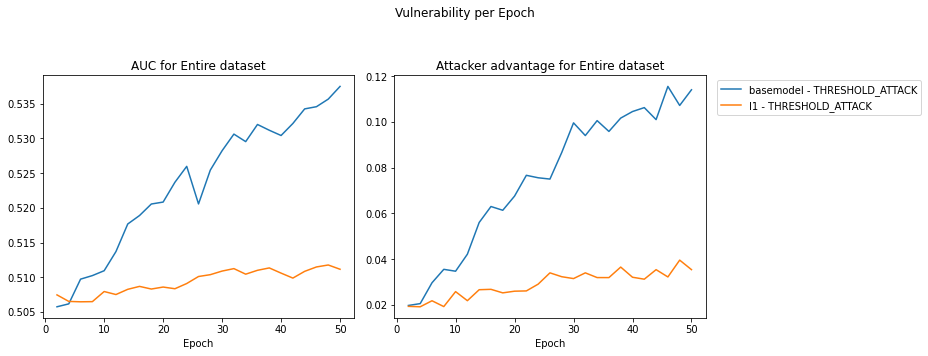

In [26]:
results_tr = AttackResultsCollection(mnist_reports_tr)
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results_tr, privacy_metrics=privacy_metrics)

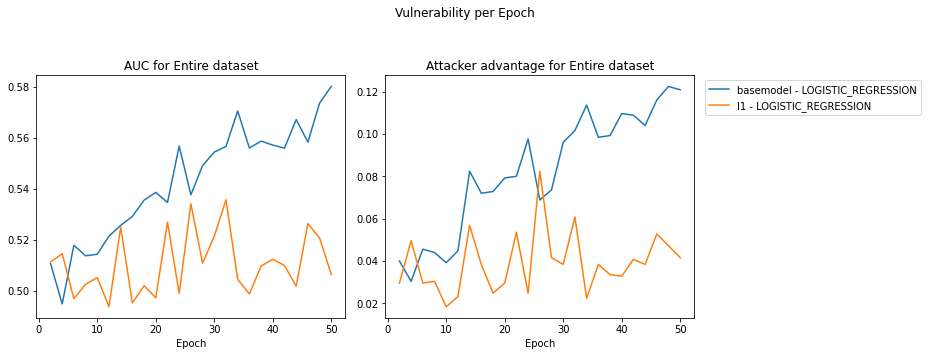

In [27]:
results_lr = AttackResultsCollection(mnist_reports_lr)
epoch_plot = privacy_report.plot_by_epochs(results_lr, privacy_metrics=privacy_metrics)

In [28]:
#dill.dump_session('mia_tfp_mmist_001.db')

## L2 regularization

In [29]:
regL2 = tf.keras.regularizers.L2(l2=reg_lambda)

model_l2 = small_cnn(input_shape, num_classes, num_conv=2, regularizer=regL2, 
                       activation=activation)

In [30]:
fit_and_report('l2', model_l2, x_train, y_train, x_valid, y_valid, total_epochs, 
              mnist_reports_tr, mnist_reports_lr)

Epoch 1/50
540/540 [==============================] - 6s 10ms/step - loss: 0.8217 - accuracy: 0.7426 - val_loss: 0.6043 - val_accuracy: 0.8067
Epoch 2/50
537/540 [============================>.] - ETA: 0s - loss: 0.5560 - accuracy: 0.8247
Running privacy report for epoch: 2

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 2

540/540 [==============================] - 13s 24ms/step - loss: 0.5554 - accuracy: 0.8250 - val_loss: 0.5382 - val_accuracy: 0.8317
Epoch 3/50
540/540 [==============================] - 5s 9ms/step - loss: 0.5085 - accuracy: 0.8408 - val_loss: 0.5226 - val_accuracy: 0.8397
Epoch 4/50
538/540 [============================>.] - ETA: 0s - loss: 0.4797 - accuracy: 0.8519
Running privacy report for epoch: 4

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 4

540/540 [==============================] - 13s 24ms/step - loss: 0.4798 - accuracy: 0.8519 - val_loss: 0.4799 - val_accuracy: 0.85

In [31]:
model_l2.evaluate(x_test,y_test)

157/157 [==============================] - 1s 3ms/step - loss: 0.3574 - accuracy: 0.8910


[0.35740265250205994, 0.890999972820282]

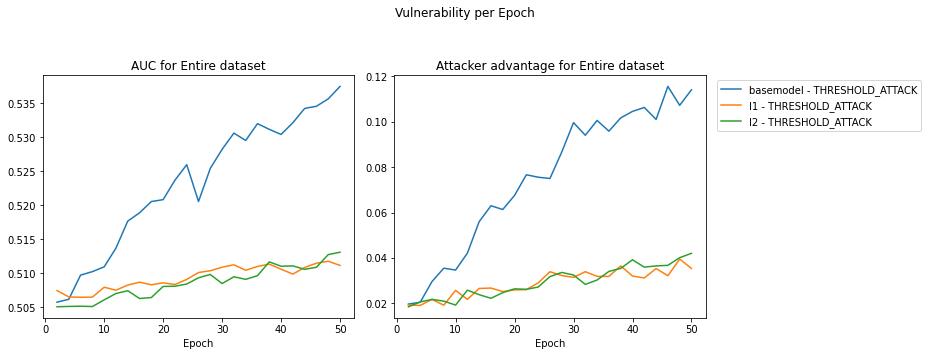

In [32]:
results_tr = AttackResultsCollection(mnist_reports_tr)
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results_tr, privacy_metrics=privacy_metrics)

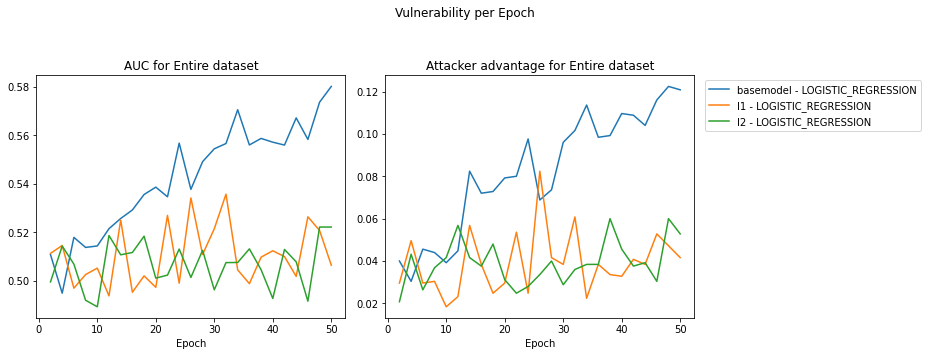

In [33]:
results_lr = AttackResultsCollection(mnist_reports_lr)
epoch_plot = privacy_report.plot_by_epochs(results_lr, privacy_metrics=privacy_metrics)

In [34]:
#dill.dump_session('mia_tfp_mmist_001.db')

## L1L2

In [35]:
regL1L2 = tf.keras.regularizers.L1L2(l2=reg_lambda, l1=reg_lambda)

model_l1l2 = small_cnn(input_shape, num_classes, num_conv=2, regularizer=regL1L2, 
                       activation=activation)

In [ ]:
fit_and_report('l1l2', model_l1l2, x_train, y_train, x_valid, y_valid, total_epochs, 
              mnist_reports_tr, mnist_reports_lr)

Epoch 1/50
540/540 [==============================] - 6s 11ms/step - loss: 1.4552 - accuracy: 0.7103 - val_loss: 0.8139 - val_accuracy: 0.7927
Epoch 2/50
539/540 [============================>.] - ETA: 0s - loss: 0.7504 - accuracy: 0.7988
Running privacy report for epoch: 2

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 2

540/540 [==============================] - 13s 25ms/step - loss: 0.7503 - accuracy: 0.7989 - val_loss: 0.7124 - val_accuracy: 0.8077
Epoch 3/50
540/540 [==============================] - 5s 10ms/step - loss: 0.6819 - accuracy: 0.8129 - val_loss: 0.6533 - val_accuracy: 0.8097
Epoch 4/50
538/540 [============================>.] - ETA: 0s - loss: 0.6160 - accuracy: 0.8243
Running privacy report for epoch: 4

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 4

540/540 [==============================] - 13s 24ms/step - loss: 0.6159 - accuracy: 0.8242 - val_loss: 0.6052 - val_accuracy: 0.8

In [ ]:
model_l1l2.evaluate(x_test,y_test)

In [ ]:
results_tr = AttackResultsCollection(mnist_reports_tr)
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results_tr, privacy_metrics=privacy_metrics)

In [ ]:
results_lr = AttackResultsCollection(mnist_reports_lr)
epoch_plot = privacy_report.plot_by_epochs(results_lr, privacy_metrics=privacy_metrics)

In [ ]:
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(
    results_tr, privacy_metrics=privacy_metrics)

for axis in utility_privacy_plot.axes:
  axis.set_xlabel('Validation accuracy')

In [ ]:
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(
    results_lr, privacy_metrics=privacy_metrics)

for axis in utility_privacy_plot.axes:
  axis.set_xlabel('Validation accuracy')

In [ ]:
#dill.dump_session('mia_tfp_mmist_001.db')